In [232]:
from tqdm import tqdm

import torch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

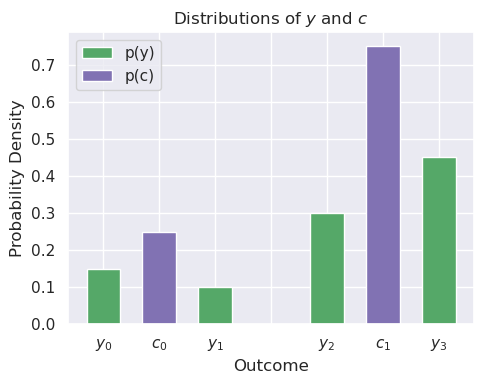

In [244]:
probs = torch.tensor([0.15, 0.1, 0.3, 0.45])
cluster_probs = torch.tensor([torch.sum(probs[:2]), torch.sum(probs[2:])])

full_dist = torch.distributions.Categorical(probs=probs)
cluster_dist = torch.distributions.Categorical(probs=cluster_probs)

plt.figure(figsize=(5, 4))
plt.bar(torch.arange(4), probs, width=0.3, color="C2")
plt.bar(torch.tensor([0.5, 2.5]), cluster_probs, width=0.3, color="C4")
plt.legend(["p(y)", "p(c)"])
plt.title("Distributions of $y$ and $c$")
plt.ylabel("Probability Density")
plt.xlabel("Outcome")
plt.xticks(torch.arange(0, 3.5, 0.5), labels=["$y_0$", "$c_0$", "$y_1$", "", "$y_2$", "$c_1$", "$y_3$"])
plt.tight_layout()
plt.savefig("py_pc.pdf")
plt.show()

In [234]:
n_seeds = 200
n_samples = 50

In [235]:
def estimate_p_c(samples: torch.Tensor):
    p_c_0 = (len(samples[samples == 0]) + len(samples[samples == 1])) / len(samples)
    return torch.tensor([p_c_0, 1 - p_c_0])

def estimate_p_c_given_p_y(samples: torch.Tensor, p_y: torch.Tensor):
    p_c_0 = torch.nan_to_num(torch.sum(p_y[(samples == 0) | (samples == 1)]) / len(samples[(samples == 0) | (samples == 1)]))
    p_c_1 = torch.nan_to_num(torch.sum(p_y[(samples == 2) | (samples == 3)]) / len(samples[(samples == 2) | (samples == 3)]))
    p_c_0 = p_c_0 / len(samples)
    p_c_1 = p_c_1 / len(samples)
    # normalize for proper distribution
    p_c_0 = p_c_0 / (p_c_0 + p_c_1)
    return torch.tensor([p_c_0, 1 - p_c_0])

In [236]:
all_p_c, all_p_c_given_p_y = list(), list()
for seed in tqdm(range(n_seeds)):
    torch.manual_seed(seed)

    full_samples = full_dist.sample([n_samples])
    full_probs = probs[full_samples]

    p_cs, p_cs_given_p_y = list(), list()
    for i in range(1, len(full_samples) + 1):

        p_cs.append(estimate_p_c(full_samples[:i]))
        p_cs_given_p_y.append(estimate_p_c_given_p_y(full_samples[:i], full_probs[:i]))

    all_p_c.append(torch.stack(p_cs, dim=0))
    all_p_c_given_p_y.append(torch.stack(p_cs_given_p_y, dim=0))

all_p_c = torch.stack(all_p_c, dim=0)
all_p_c_given_p_y = torch.stack(all_p_c_given_p_y, dim=0)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:03<00:00, 63.58it/s]


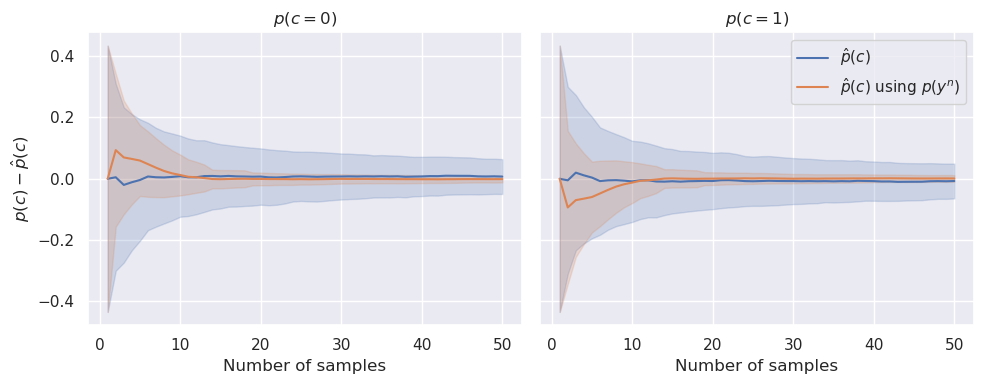

In [242]:
x = range(1, all_p_c.shape[1] + 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i in range(2):
    delta_probs = cluster_probs[i] - all_p_c[..., i]
    axs[i].plot(x, torch.mean(delta_probs, dim=0), label="$\hat p(c)$")
    axs[i].fill_between(x,
                    torch.mean(delta_probs, dim=0) + torch.std(delta_probs, dim=0),
                    torch.mean(delta_probs, dim=0) - torch.std(delta_probs, dim=0), 
                    color="C0", alpha=0.2)
for i in range(2):
    delta_probs = cluster_probs[i] - all_p_c_given_p_y[..., i]
    axs[i].plot(x, torch.mean(delta_probs, dim=0), label="$\hat p(c)$ using $p(y^n)$")
    axs[i].fill_between(x,
                    torch.mean(delta_probs, dim=0) + torch.std(delta_probs, dim=0),
                    torch.mean(delta_probs, dim=0) - torch.std(delta_probs, dim=0), 
                    color="C1", alpha=0.2)
    
    axs[i].set_title(f"$p(c = {i})$")
    axs[i].set_xlabel("Number of samples")

axs[1].legend()
axs[0].set_ylabel("$p(c) - \hat p(c)$")
plt.tight_layout()
plt.savefig("mc_approximation_pc.pdf")
plt.show()